In [1]:
# this allows you to use "cd" in cells to change directories instead of requiring "%cd"
%automagic on
# override IPython's default %%bash to not buffer all output
from IPython.core.magic import register_cell_magic
@register_cell_magic
def bash(line, cell): get_ipython().system(cell)
# Some versions of OpenMPI prevent oversubscribing cpus, which may happen if simfactory's
# number of cores detection is imperfect.
# OpenMPI by default pins MPI ranks to specific cores, which causes issues on shared
# system like the tutorial cluster.
# OpenMPI contains a bug affecting MPI calls with large amounts of data on slow systems,
# which can lead to hangs (OpenMPI issue 6568).
import os
os.environ["OMPI_MCA_rmaps_base_oversubscribe"] = "true"
os.environ["OMPI_MCA_hwloc_base_binding_policy"] = "none"
os.environ["OMPI_MCA_btl_vader_single_copy_mechanism"] = "none"
import scrolldown


Automagic is ON, % prefix IS NOT needed for line magics.


<IPython.core.display.Javascript object>

In [2]:
cd ~

/home/bgiacoma


We need to download the initial data. Here we use an equal-mass BNS system computed with LORENE using a piece-wise polytropic approximation of the SLY4 EOS.

In [3]:
!wget https://einsteintoolkit.github.io/et2021uiuc/lectures/05-BrunoGiacomazzo/ETK_School_2021.tgz

--2021-07-25 09:57:18--  https://einsteintoolkit.github.io/et2021uiuc/lectures/05-BrunoGiacomazzo/ETK_School_2021.tgz
Resolving einsteintoolkit.github.io (einsteintoolkit.github.io)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
Connecting to einsteintoolkit.github.io (einsteintoolkit.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 189491 (185K) [application/octet-stream]
Saving to: ‘ETK_School_2021.tgz.3’

ETK_School_2021.tgz 100%[===================>] 185.05K  --.-KB/s    in 0.03s   

2021-07-25 09:57:18 (7.20 MB/s) - ‘ETK_School_2021.tgz.3’ saved [189491/189491]



In [4]:
!tar xzvf ETK_School_2021.tgz

ETK_School_2021/
ETK_School_2021/prof_loggam.d
ETK_School_2021/resdiffm.d
ETK_School_2021/par_init.d
ETK_School_2021/identif.d
ETK_School_2021/resstar2.d
ETK_School_2021/par_grid2.d
ETK_School_2021/parcoal.d
ETK_School_2021/par_eos2.d
ETK_School_2021/resconv2.d
ETK_School_2021/prof_logn.d
ETK_School_2021/resconv1.d
ETK_School_2021/resu.d
ETK_School_2021/resrota.d
ETK_School_2021/par_eos1.d
ETK_School_2021/resglob.d
ETK_School_2021/resformat.d
ETK_School_2021/resstar1.d
ETK_School_2021/ini.d
ETK_School_2021/par_grid1.d
ETK_School_2021/calcul.d


In [5]:
!ls

Cactus				 ETK_School_2021.tgz.1
CactusSourceJar.git		 ETK_School_2021.tgz.2
CactusTutorial.ipynb		 ETK_School_2021.tgz.3
CreatingANewThorn-HeatEqn.ipynb  GetComponents
CreatingANewThorn-WaveEqn.ipynb  Giacomazzo_ETK_2021.ipynb
einsteintoolkit.th		 simulations
ETK_School_2021			 VisualizingOutput-WaveMoL.ipynb
ETK_School_2021.tgz


In [6]:
!cat ETK_School_2021/par_eos1.d

110    Type of the EOS (cf. documentation of Eos::eos_from_file)
Star 1  EOS
7                       number of polytropes
1.58425                 array of adiabatic index
1.28733
0.62223
1.35692
3.005
2.988
2.851
6.8011e-09
3.53623
7.3875                 array of the exponent of fiducial densities logRho
11.5779
12.4196
14.165
14.7
15
0.                      array of percentage
0.
0.
0.
0.
0.



Now we need to convert those values in Cactus units in order to use them with EOS_Omni

In [7]:
#conversion factors
k0_cgs=6.8011e-09 #this is the polytropic constant at the lowest density in cgs units
cu_to_cgs=6.1762691458861658e+17 #convert from CU to g/cm^3
gamma=1.58425 #this is gamma at the lowest density iterval (outer crust)

K_cgs = K_cu * cu_to_cgs^(1-gamma)<br>
K_cu = K_cgs * cu_to_cgs^(gamma-1)

In [8]:
#we get k0 in Cactus units
Kcu=k0_cgs*(cu_to_cgs**(gamma-1))
print(Kcu)

168.58190246577206


In [9]:
import numpy as np
rho_cgs = np.array([10**7.3875, 10**11.5779, 10**12.4196, 10**14.165, 10**14.7, 10**15])
print(rho_cgs)

[2.44061907e+07 3.78355455e+11 2.62784654e+12 1.46217717e+14
 5.01187234e+14 1.00000000e+15]


and now we get the dividing densities in Cactus units ($c=G=M_\odot=1$)

In [10]:
rho_cu=rho_cgs/cu_to_cgs
print(rho_cu)

[3.95160737e-11 6.12595478e-07 4.25474745e-06 2.36741168e-04
 8.11472463e-04 1.61910043e-03]


We now go back to the Cactus directory and create a parameter file to read in the initial data and use the values we just computed in order to set EOS_Omni parameters

In [11]:
cd ~/Cactus

/home/bgiacoma/Cactus


In [12]:
%%bash
cat >par/BNS_ETK_July_2021_Sly4.par <<"#EOF"
ActiveThorns = "
  admanalysis
  admbase
  admcoupling
  admmass
  admmacros
  aeilocalinterp
  ahfinderdirect
  Hydro_Analysis
  boundary
  carpet
  carpetinterp
  carpetioascii
  carpetiobasic
  carpetiohdf5
  carpetioscalar
  carpetlib
  carpetreduce
  carpetregrid2
  cartgrid3d
  coordbase
  coordgauge
  dissipation
  EOS_Omni 
  formaline
  fortran
  genericfd
  hydrobase
  initbase
  ioutil
  localinterp
  loopcontrol
  ml_admconstraints
  ml_bssn
  ml_bssn_helper
  mol
  multipole
  nanchecker
  newrad
  quasilocalmeasures
  reflectionsymmetry
  spacemask
  sphericalsurface
  staticconformal
  summationbyparts
  symbase
  terminationtrigger
  time
  timerreport
  tmunubase
  systemstatistics
  GRHydro
  Meudon_Bin_NS
"


#=========================================
# Output
#=========================================

#------------------ioutil------------------------------------------------------

ioutil::abort_on_io_errors               = yes
##ioutil::checkpoint_dir                   = "../checkpoint"
##ioutil::checkpoint_every                 = 2048
##ioutil::checkpoint_id                    = no
##ioutil::checkpoint_keep                  = 2
##ioutil::checkpoint_on_terminate          = yes
ioutil::out_dir                          = "Misc"
ioutil::parfile_write                    = "generate"
ioutil::print_timing_info                = yes
##ioutil::recover                          = "autoprobe"
##ioutil::recover_dir                      = "../checkpoint"
ioutil::strict_io_parameter_check        = yes
##ioutil::verbose                          = "full"

#------------------carpetiobasic-----------------------------------------------

carpetiobasic::outinfo_every             = 64
carpetiobasic::outinfo_reductions        = "norm_inf"
carpetiobasic::outinfo_vars = "
  hydrobase::rho
  ml_admconstraints::ml_ham
"

#------------------carpetioscalar----------------------------------------------

carpetioscalar::outscalar_criterion      = "divisor"
carpetioscalar::outscalar_dir            = "Scalars"
carpetioscalar::outscalar_every          = 64
carpetioscalar::outscalar_reductions     = "minimum maximum norm1 norm2 norm_inf"
carpetioscalar::outscalar_vars = "
  admbase::lapse{reductions='minimum maximum'}
  hydrobase::eps{reductions='minimum maximum'}
  hydrobase::press{reductions='minimum maximum'}
  hydrobase::rho{reductions='minimum maximum'}
  hydrobase::vel{reductions='norm_inf'}
  hydrobase::w_lorentz{reductions='maximum'}
  ml_admconstraints::ml_ham{reductions='norm_inf norm1 norm2'}
  ml_admconstraints::ml_mom{reductions='norm_inf norm1 norm2'}
  carpet::memory_procs{reductions='minimum maximum average'}
"

#------------------carpetioascii-----------------------------------------------

carpetioascii::out0d_criterion           = "divisor"
carpetioascii::out0d_every               = 64
carpetioascii::out0d_dir                 = "Scalars"
carpetioascii::out0d_vars = "
  admmass::admmass_masses
  carpet::timing
  carpetregrid2::positions
  hydro_analysis::total_rest_mass
"

#------------------carpetiohdf5------------------------------------------------

carpetiohdf5::checkpoint                    = yes
carpetiohdf5::compression_level             = 0
carpetiohdf5::open_one_input_file_at_a_time = yes


carpetiohdf5::out2d_dir                  = "hdf5_2D"
carpetiohdf5::out2d_every                = 1280
carpetiohdf5::out2D_criterion            = "divisor"
carpetiohdf5::out2d_vars = "
  admbase::lapse
  admbase::metric
  admbase::shift
  hydrobase::eps
  hydrobase::rho{out_every=256}
  hydrobase::press
  hydrobase::vel
  hydrobase::w_lorentz
  ml_admconstraints::ml_ham{out_every=256}
"

carpetiohdf5::out_dir                    = "hdf5_3D"
carpetiohdf5::out_every                  = 5248
carpetiohdf5::out3D_criterion            = "divisor"
carpetiohdf5::out_vars = "
  admbase::lapse
  hydrobase::rho
  hydrobase::eps
"

carpetiohdf5::use_checksums              = yes
carpetiohdf5::use_grid_structure_from_checkpoint = yes

#------------------timerreport-------------------------------------------------

timerreport::out_every                   = 2048
timerreport::out_filename                = "timer_report.txt"
timerreport::output_all_timers_readable  = yes
timerreport::output_all_timers           = yes


#=========================================
# Initial data
#=========================================

#------------------initbase----------------------------------------------------

initbase::initial_data_setup_method      = "init_some_levels"

#------------------Meudon_Bin_NS-------------------------------------------

Meudon_Bin_NS::filename	          = "/home/bgiacoma/ETK_School_2021/resu.d"

#=========================================
# Grid
#=========================================

#------------------reflectionsymmetry------------------------------------------

reflectionsymmetry::avoid_origin_x       = no
reflectionsymmetry::avoid_origin_y       = no
reflectionsymmetry::avoid_origin_z       = no
reflectionsymmetry::reflection_x         = no
reflectionsymmetry::reflection_y         = no
reflectionsymmetry::reflection_z         = yes

#------------------coordbase---------------------------------------------------

coordbase::boundary_size_x_lower         = 3
coordbase::boundary_size_x_upper         = 3
coordbase::boundary_size_y_lower         = 3
coordbase::boundary_size_y_upper         = 3
coordbase::boundary_size_z_lower         = 3
coordbase::boundary_size_z_upper         = 3

coordbase::boundary_shiftout_z_lower     = 1 #because we are using reflection symmetry at z=0

coordbase::domainsize                    = "minmax"
coordbase::dx                            = 0.3
coordbase::dy                            = 0.3
coordbase::dz                            = 0.3
coordbase::xmax                          = 30
coordbase::xmin                          = -30
coordbase::ymax                          = 30
coordbase::ymin                          = -30
coordbase::zmax                          = 12
coordbase::zmin                          = 0

#------------------cartgrid3d--------------------------------------------------

cartgrid3d::type                         = "coordbase"


#=========================================
# Cactus/Carpet/ET
#=========================================

#------------------cactus------------------------------------------------------

cactus::cctk_final_time                  = 0
cactus::cctk_full_warnings               = yes
cactus::cctk_run_title                   = "BNS ETK 2021"
##cactus::cctk_timer_output                = "full"
cactus::terminate                        = "time"

#------------------terminationtrigger------------------------------------------

terminationtrigger::create_termination_file  = yes
terminationtrigger::max_walltime             = 24
terminationtrigger::on_remaining_walltime    = 60
terminationtrigger::termination_file         = "../TERMINATE"
terminationtrigger::termination_from_file    = yes

#------------------loopcontrol-------------------------------------------------

loopcontrol::random_jump_probability     = 0


#------------------carpetlib---------------------------------------------------

carpetlib::print_memstats_every          = 2048
carpetlib::print_timestats_every         = 2048
##CarpetLib::support_staggered_operators   = "yes" #needed if you use IGM or Spritz instead of GRHydro

#------------------carpet------------------------------------------------------

carpet::convergence_level                = 0
carpet::domain_from_coordbase            = yes
carpet::enable_all_storage               = no
carpet::ghost_size                       = 3
carpet::init_each_timelevel              = no
carpet::init_fill_timelevels             = yes
carpet::max_refinement_levels            = 7
carpet::num_integrator_substeps          = 4
carpet::output_timer_tree_every          = 0
carpet::output_timers_every              = 0
carpet::prolongation_order_space         = 5
carpet::prolongation_order_time          = 2
carpet::regrid_during_initialisation     = no
carpet::regrid_during_recovery           = no
carpet::regrid_in_level_mode             = yes
carpet::timer_file                       = ""
carpet::use_buffer_zones                 = yes
carpet::verbose                          = no
Carpet::grid_coordinates_filename        = "carpet.grid"


#------------------hydrobase---------------------------------------------------

hydrobase::evolution_method              = "GRHydro"
hydrobase::prolongation_type             = "ENO"
hydrobase::timelevels                    = 3
hydrobase::initial_hydro                 = "Meudon_Bin_NS"

#------------------admbase-----------------------------------------------------

admbase::dtlapse_evolution_method        = "ML_BSSN"
admbase::dtshift_evolution_method        = "ML_BSSN"
admbase::evolution_method                = "ML_BSSN"

admbase::initial_data                    = "Meudon_Bin_NS"
admbase::initial_dtlapse                 = "zero"
admbase::initial_dtshift                 = "zero"
admbase::initial_lapse                   = "Meudon_Bin_NS"
admbase::initial_shift                   = "zero"

admbase::lapse_evolution_method          = "ML_BSSN"
admbase::metric_type                     = "physical"
admbase::shift_evolution_method          = "ML_BSSN"


#=========================================
# Evolution
#=========================================

#------------------time--------------------------------------------------------

time::dtfac                              = 0.35

#------------------mol---------------------------------------------------------

mol::mol_intermediate_steps              = 4
mol::mol_num_scratch_levels              = 1
mol::ode_method                          = "rk4"


#------------------ml_bssn-----------------------------------------------------
ML_BSSN::rhs_boundary_condition          = "NewRad"
ML_BSSN::initial_boundary_condition      = "extrapolate-gammas"
ml_bssn::betadriver                      = 0.368 # = 1/M_tot , with M_tot = 2.72
ml_bssn::harmonicf                       = 2 #1+log
ml_bssn::harmonicn                       = 1 #1+log
ml_bssn::advectLapse                     = 1
ml_bssn::minimumlapse                    = 1e-08
ml_bssn::advectShift                     = 1
ml_bssn::shiftgammacoeff                 = 0.75

#------------------dissipation-------------------------------------------------

dissipation::epsdis                      = 0.1
dissipation::order                       = 5
dissipation::vars = "
  ml_bssn::ml_curv
  ml_bssn::ml_dtlapse
  ml_bssn::ml_dtshift
  ml_bssn::ml_gamma
  ml_bssn::ml_lapse
  ml_bssn::ml_log_confac
  ml_bssn::ml_metric
  ml_bssn::ml_shift
  ml_bssn::ml_trace_curv
"

#------------------tmunubase---------------------------------------------------

tmunubase::prolongation_type             = "none"
tmunubase::stress_energy_at_rhs          = yes
tmunubase::stress_energy_storage         = yes
tmunubase::timelevels                    = 1

#------------------EOS---------------------------------------------------------
EOS_Omni::hybrid_gamma_th = 1.8 #gamma thermal from Hotokezaka et al. 2013 (arxiv.org/abs/1307.5888)

EOS_Omni::n_pieces = 7 #3 for the core + 4 for the crust (Read et al 2009)

## k0=6.8011e-09 in cgs units 
##  and Kcu = k0_cgs*(cu_to_cgs**(gamma-1))
##  where cu_to_cgs=6.1762691458861658e+17 converts from CU to g/cm^3
EOS_Omni::hybrid_k0 = 168.58190246577206 

EOS_Omni::hybrid_gamma[0] = 1.58425
EOS_Omni::hybrid_gamma[1] = 1.28733
EOS_Omni::hybrid_gamma[2] = 0.62223
EOS_Omni::hybrid_gamma[3] = 1.35692
EOS_Omni::hybrid_gamma[4] = 3.005
EOS_Omni::hybrid_gamma[5] = 2.988
EOS_Omni::hybrid_gamma[6] = 2.851

EOS_Omni::hybrid_rho[0] = 3.95160737e-11
EOS_Omni::hybrid_rho[1] = 6.12595478e-07
EOS_Omni::hybrid_rho[2] = 4.25474745e-06
EOS_Omni::hybrid_rho[3] = 2.36741168e-04
EOS_Omni::hybrid_rho[4] = 8.11472463e-04
EOS_Omni::hybrid_rho[5] = 1.61910043e-03


#------------------GRHydro------------------------------------------------------
GRHydro::recon_method = "ppm"
GRHydro::ppm_detect = "yes"
GRHydro::riemann_solver = "HLLE" #default value
GRHydro::bound = "flat"
GRHydro::GRHydro_stencil = 3
GRHydro::GRHydro_eos_type = "General"
GRHydro::GRHydro_eos_table = "Hybrid" ##PPEOS + gamma-law
GRHydro::rho_abs_min = 1e-13
GRHydro::GRHydro_atmo_tolerance = 0.001



#------------------summationbyparts--------------------------------------------

summationbyparts::order                  = 4

#------------------boundary----------------------------------------------------

boundary::radpower                       = 2

#------------------spacemask---------------------------------------------------

spacemask::use_mask                      = yes


#------------------admmass-----------------------------------------------------

admmass::admmass_surface_distance[0]     = 20
admmass::admmass_use_all_volume_as_volume_radius = no
admmass::admmass_use_surface_distance_as_volume_radius = no
admmass::admmass_volume_radius[0]        = 20 

#------------------nanchecker--------------------------------------------------

nanchecker::action_if_found              = "abort"
nanchecker::check_after                  = 0
nanchecker::check_every                  = 128
nanchecker::check_vars = "
  hydrobase::rho
  hydrobase::w_lorentz
"
nanchecker::out_nanmask                  = yes


#-------Hydro_Analysis-----------------------
Hydro_Analysis::restmass_rho_min        = 1e-13 #this should be equal to rho_abs_min
Hydro_Analysis::restmass_masses_nr      = 0 #zero means compute only the total baryonic mass
Hydro_Analysis::restmass_compute_masses = yes

#EOF

Now we create the simulation

In [13]:
%%bash
# create simulation directory structure
rm -fr ~/simulations/BNS_ET
./simfactory/bin/sim create BNS_ET --configuration sim --parfile=par/BNS_ETK_July_2021_Sly4.par

Parameter file: /home/bgiacoma/Cactus/par/BNS_ETK_July_2021_Sly4.par
Skeleton Created
Job directory: "/home/bgiacoma/simulations/BNS_ET"
Executable: "/home/bgiacoma/Cactus/exe/cactus_sim"
Option list: "/home/bgiacoma/simulations/BNS_ET/SIMFACTORY/cfg/OptionList"
Submit script: "/home/bgiacoma/simulations/BNS_ET/SIMFACTORY/run/SubmitScript"
Run script: "/home/bgiacoma/simulations/BNS_ET/SIMFACTORY/run/RunScript"
Parameter file: "/home/bgiacoma/simulations/BNS_ET/SIMFACTORY/par/BNS_ETK_July_2021_Sly4.par"


and now we submit it

In [14]:
%%bash
# start simulation segment
./simfactory/bin/sim submit BNS_ET --cores=1 --num-threads=1 --walltime=0:20:00

Assigned restart id: 0 
Executing submit command: exec nohup /home/bgiacoma/simulations/BNS_ET/output-0000/SIMFACTORY/SubmitScript < /dev/null > /home/bgiacoma/simulations/BNS_ET/output-0000/BNS_ET.out 2> /home/bgiacoma/simulations/BNS_ET/output-0000/BNS_ET.err & echo $!
Submit finished, job id is 27651


In [18]:
%%bash
# watch log output
./simfactory/bin/sim show-output BNS_ET

Simulation name: BNS_ET
The job's Formaline output is:
(file does not exist)
The job's stdout is:
Simulation name: BNS_ET
Running simulation BNS_ET
Preparing:
Checking:
/home/bgiacoma/simulations/BNS_ET/output-0000-active
etk1.cct.lsu.edu
Sun Jul 25 09:58:30 UTC 2021
Environment:
Starting:
INFO (Cactus): Increased logging level from 0 to 3
--------------------------------------------------------------------------------

       10                                  
  1   0101       ************************  
  01  1010 10      The Cactus Code V4.10.0    
 1010 1101 011      www.cactuscode.org     
  1001 100101    ************************  
    00010101                               
     100011     (c) Copyright The Authors  
      0100      GNU Licensed. No Warranty  
      0101                                 
--------------------------------------------------------------------------------

Cactus version:    4.10.0
Compile date:      Jul 23 2021 (15:41:42)
Run date:          Jul 25 2

In [20]:
%%bash
./simfactory/bin/sim list-simulations

   BNS_ET                  [ACTIVE (FINISHED), restart 0000, job id 27651]
   helloworld              [ACTIVE (FINISHED), restart 0000, job id -1]
   tov_ET                  [ACTIVE (FINISHED), restart 0000, job id 9219]


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit.simdir import SimDir
from kuibit.grid_data import UniformGrid

%matplotlib inline

In [22]:
%%bash
# show the most recent segment directory that Cactus stored its output files in
./simfactory/bin/sim get-output-dir BNS_ET

/home/bgiacoma/simulations/BNS_ET/output-0000


In [23]:
gf = SimDir("/home/bgiacoma/simulations/BNS_ET/output-0000").gf

print(gf)


Available grid data of dimension 1D (x): 
[]


Available grid data of dimension 1D (y): 
[]


Available grid data of dimension 1D (z): 
[]


Available grid data of dimension 2D (xy): 
['vel[2]', 'gyy', 'H', 'betax', 'vel[1]', 'betaz', 'vel[0]', 'rho', 'w_lorentz', 'betay', 'gzz', 'gxx', 'alp', 'gxz', 'gxy', 'gyz', 'eps', 'press']


Available grid data of dimension 2D (xz): 
['vel[1]', 'betax', 'press', 'alp', 'vel[2]', 'H', 'vel[0]', 'gyy', 'w_lorentz', 'gzz', 'gxy', 'gyz', 'betaz', 'gxx', 'betay', 'gxz', 'rho', 'eps']


Available grid data of dimension 2D (yz): 
['w_lorentz', 'gyy', 'H', 'gzz', 'betaz', 'eps', 'vel[1]', 'alp', 'vel[0]', 'betax', 'press', 'betay', 'gxz', 'gxy', 'vel[2]', 'gxx', 'gyz', 'rho']


Available grid data of dimension 3D (xyz): 
['eps', 'alp', 'rho']



In [25]:
vars2D = gf.xy  # gf[(0, 1)] would work fine
vars3D = gf.xyz

print(vars2D)
print(vars3D)


Available grid data of dimension 2D (xy): 
['vel[2]', 'gyy', 'H', 'betax', 'vel[1]', 'betaz', 'vel[0]', 'rho', 'w_lorentz', 'betay', 'gzz', 'gxx', 'alp', 'gxz', 'gxy', 'gyz', 'eps', 'press']


Available grid data of dimension 3D (xyz): 
['eps', 'alp', 'rho']



In [26]:
rho_b = vars2D.fields.rho  # vars2D['rho_b'] would be fine

In [27]:
rho0 = rho_b[0]  # this is rho at iteration 0
# rho0 = rho_b.get_iteration(0) is equivalent

# To know what iterations are available:
print(rho_b.iterations)

print("rho0 is a", type(rho0))
print(f"The value of rho0 at the point (1, 2) is {rho0((1, 2))}")

[0]
rho0 is a <class 'kuibit.grid_data.HierarchicalGridData'>
The value of rho0 at the point (1, 2) is 1e-13


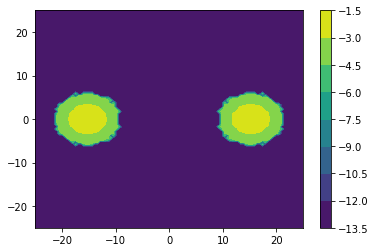

In [28]:
small_grid = UniformGrid([100, 100], x0=[-25, -25], x1=[25,25])

rho0_small = rho_b.read_on_grid(0, small_grid)

cf = plt.contourf(*rho0_small.coordinates_meshgrid(), np.log10(rho0_small.data_xyz))
plt.colorbar(cf)